In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env
import wrangle

new_logs_data()
get_logs_data()
prepare(df)


## Acquire and Prepare


In [2]:
df = wrangle.get_logs_data()

In [3]:
df.head()

,time,endpoint,user,source_ip,cohort_name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0



# Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         900223 non-null  object 
 1   endpoint     900222 non-null  object 
 2   user         900223 non-null  int64  
 3   source_ip    900223 non-null  object 
 4   cohort_name  847330 non-null  object 
 5   start_date   847330 non-null  object 
 6   end_date     847330 non-null  object 
 7   program_id   847330 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 61.8+ MB


In [5]:
df.start_date = pd.to_datetime(df.start_date)

In [6]:
df.end_date = pd.to_datetime(df.end_date)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         900223 non-null  object        
 1   endpoint     900222 non-null  object        
 2   user         900223 non-null  int64         
 3   source_ip    900223 non-null  object        
 4   cohort_name  847330 non-null  object        
 5   start_date   847330 non-null  datetime64[ns]
 6   end_date     847330 non-null  datetime64[ns]
 7   program_id   847330 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 61.8+ MB


In [8]:
df_cont_access =  df[df.index > df.end_date]

In [9]:
df_cont_access.user.unique()

array([  1,  11,  21,  26,  37,  40,  50,  51,  53,  60,  64,  66,  67,
        68,  69,  70,  71,  72,  75,  76,  77,  80,  81,  82,  83,  84,
        85,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98, 101, 102,
        16,  42,  41,  17,  22,  15, 104,  47,  57,  10, 105, 106,  28,
       107,  65,  52,  33,  56, 108,  27,  38,  36, 109, 110, 112, 113,
       114, 115, 139, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151,
       152, 153, 156, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172,
       173, 174, 175, 177, 178, 179,  29,  19, 180,   6,  99,  43,  31,
         7, 181, 138,  35, 142,   5, 155, 154,  88, 209, 210,  18,   3,
        20, 118, 211, 212, 214, 216, 217, 131, 135, 128, 127, 124, 130,
       159,  12, 145, 241, 242, 136, 157, 171, 123,  25, 134, 119, 243,
       244, 245, 246, 160, 248, 252, 254, 255, 120, 257, 279, 280, 281,
        14, 253, 188, 186, 283, 184, 215, 278, 183, 204, 193, 195, 197,
       249, 206, 284, 121, 201, 285, 286, 311, 190, 312, 116, 20

# Identify students who present anomalous activity using the Bollinger Band method. K = 3, span = 30.

# Individual Views for anomolies

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         900223 non-null  object        
 1   endpoint     900222 non-null  object        
 2   user         900223 non-null  int64         
 3   source_ip    900223 non-null  object        
 4   cohort_name  847330 non-null  object        
 5   start_date   847330 non-null  datetime64[ns]
 6   end_date     847330 non-null  datetime64[ns]
 7   program_id   847330 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 61.8+ MB


In [11]:
df.user.unique();

%b, Percent Bandwidth¶

Shows where the last value sits in relation to the bands.

%b = value−LB / UB-LB

    If %b > 1, data point lies above the upper band
    If %b < 0, data point lies below the lower band
    If %b == .5, data point lies on the midband.


Upper & Lower Band

UB/LB = Midband +/- stdev * K

stdev = train.ewm(span=30).std()

K = the number of standard deviations to go up and down from the EMA


In [12]:
df.index

DatetimeIndex(['2018-01-26', '2018-01-26', '2018-01-26', '2018-01-26',
               '2018-01-26', '2018-01-26', '2018-01-26', '2018-01-26',
               '2018-01-26', '2018-01-26',
               ...
               '2021-04-21', '2021-04-21', '2021-04-21', '2021-04-21',
               '2021-04-21', '2021-04-21', '2021-04-21', '2021-04-21',
               '2021-04-21', '2021-04-21'],
              dtype='datetime64[ns]', name='date', length=900223, freq=None)

In [13]:
def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    #filters data frame to only show one user at a time
    df = df[df.user == user]
    #counts how many pulls per day for the single user mentioned above
    # note 'endpoint' has no meaning. just needed a column to resample and count by
    # the real meaning is pulls per day per user which is df.user==user and resample('d').count()
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [14]:
def compute_pct_b(pages_one_user, span, weight, user):
    ############# single user, ewm(span), weight = K, user #
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band-these are just standard equations
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe-combining data succinctly into a dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe - keep comibining
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    # eqn for %b
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    # add column to display user id
    my_df['user'] = user
    return my_df

In [15]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user-see earlier function
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return records that sit outside of bollinger band upper/lower limit
    #note: we don't expect any below the lower limit based on what we saw in the overall graph
    # the lower limit is 2(sigma) which happens to result in '-' values
    # but you can't have '-' of pulls
    return my_df[(my_df.pct_b>1) | (my_df.pct_b<0)]

In [16]:
# plot_bands function required no modifictions for this notebook from class notebook

In [17]:
def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [18]:
df.head()

,time,endpoint,user,source_ip,cohort_name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [19]:
span = 30
weight = 3

anomalies = pd.DataFrame()
for u in list(df.user.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [20]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
...,...,...,...,...,...,...
2021-04-13,42,6.722117,39.398133,-25.953900,1.039813,884
2021-04-14,67,12.322021,63.449584,-38.805542,1.034721,888
2021-04-20,53,11.548548,50.739988,-27.642892,1.028833,919


In [21]:
anomalies.user.nunique()

610

In [22]:
anomalies.user.unique()

array([  1,   3,   5,   6,   7,  10,  11,  12,  13,  14,  15,  16,  18,
        19,  20,  21,  25,  26,  27,  28,  29,  31,  32,  33,  36,  37,
        38,  40,  41,  42,  43,  48,  50,  51,  52,  53,  54,  56,  57,
        58,  59,  61,  63,  64,  65,  67,  68,  69,  70,  72,  73,  75,
        76,  78,  79,  80,  83,  84,  86,  88,  90,  92,  93,  94,  96,
        98,  99, 101, 102, 103, 105, 106, 110, 111, 112, 115, 116, 118,
       119, 120, 121, 122, 123, 124, 126, 127, 128, 130, 131, 134, 136,
       138, 139, 140, 142, 143, 145, 146, 147, 148, 151, 153, 155, 156,
       157, 159, 160, 162, 164, 166, 167, 168, 169, 170, 171, 175, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 193, 195,
       197, 198, 200, 201, 204, 206, 208, 210, 211, 213, 214, 215, 217,
       218, 219, 220, 221, 223, 224, 225, 226, 227, 230, 231, 232, 234,
       238, 239, 240, 241, 242, 243, 245, 248, 249, 251, 252, 253, 254,
       255, 256, 257, 258, 261, 262, 263, 264, 265, 266, 267, 26

# Thats a lot of anomalies. Maybe we can narrow it down further

In [23]:
def plot_bands_two(my_df, users):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    for user in users:
        temp_df = my_df[my_df.user == user]
        plt.figure()
        plt.plot(temp_df.index, temp_df.pages_one_user, label='Number of Pages, User: '+str(user))
        plt.plot(temp_df.index, temp_df.midband, label = 'EMA/midband')
        plt.plot(temp_df.index, temp_df.ub, label = 'Upper Band')
        plt.plot(temp_df.index, temp_df.lb, label = 'Lower Band')
        plt.legend()
        plt.show()

# Cohort name anomalies

In [24]:
coh_nam_na = df[df.cohort_name.isna()]
coh_nam_na.head()

,time,endpoint,user,source_ip,cohort_name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,16:46:16,/,48,97.105.19.61,NaN,NaT,NaT,NaN
2018-01-26,16:46:24,spring/extra-features/form-validation,48,97.105.19.61,NaN,NaT,NaT,NaN
2018-01-26,17:54:24,/,48,97.105.19.61,NaN,NaT,NaT,NaN
2018-01-26,18:32:03,/,48,97.105.19.61,NaN,NaT,NaT,NaN
2018-01-26,18:32:17,mysql/relationships/joins,48,97.105.19.61,NaN,NaT,NaT,NaN


In [25]:
coh_nam_na.user.unique()

array([ 48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88,
        89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 372, 375, 403, 406, 429, 544,  64, 713,
       714, 715, 716, 717, 718, 663, 719, 720, 721, 722, 723, 724, 725,
       726, 727, 728, 729, 346, 731, 736, 644, 744, 782, 810, 814, 815])

# any in common between individual anomalies and those with no cohort name?

In [26]:
np.intersect1d(coh_nam_na.user.unique(),anomalies.user.unique())

array([ 48,  54,  58,  59,  61,  63,  64,  73,  78,  79,  86,  88, 103,
       111, 166, 213, 346, 349, 351, 352, 353, 354, 358, 359, 361, 362,
       363, 364, 366, 367, 368, 369, 372, 375, 403, 406, 429, 544, 644,
       663, 713, 714, 716, 717, 718, 720, 721, 728, 729, 736, 744, 815])

In [27]:
sus = np.intersect1d(coh_nam_na.user.unique(),anomalies.user.unique())

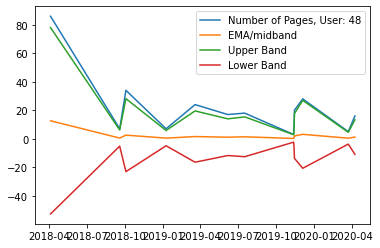

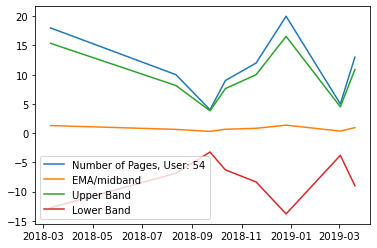

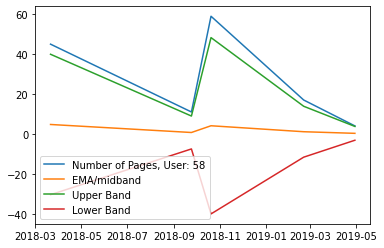

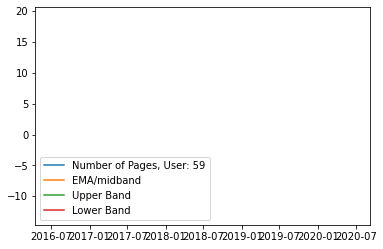

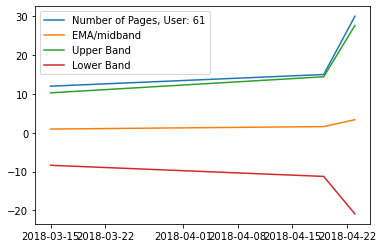

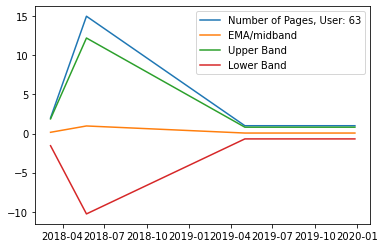

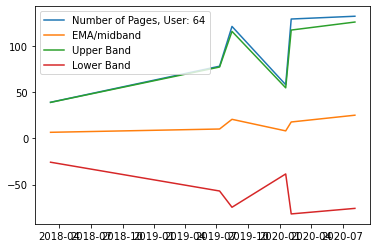

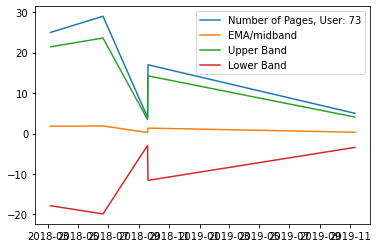

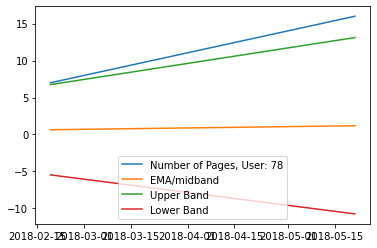

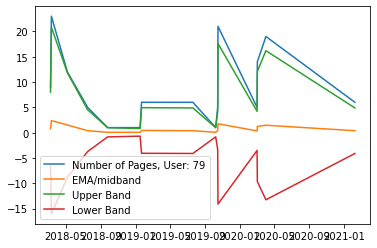

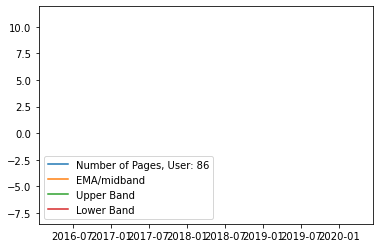

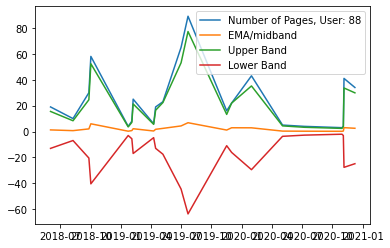

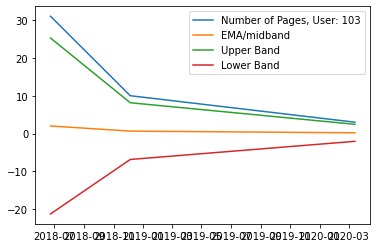

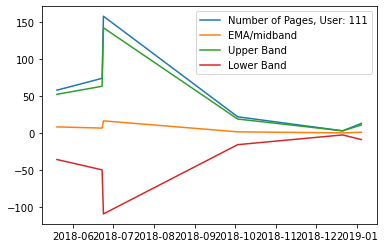

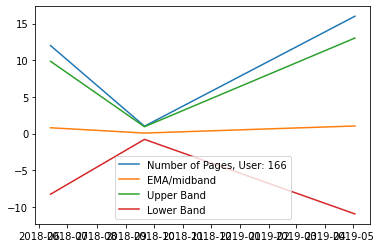

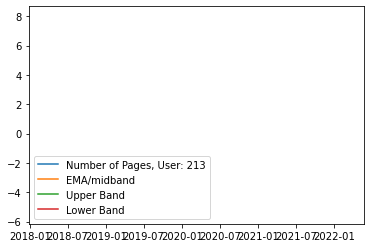

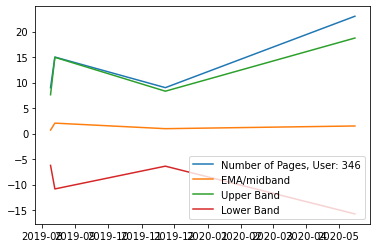

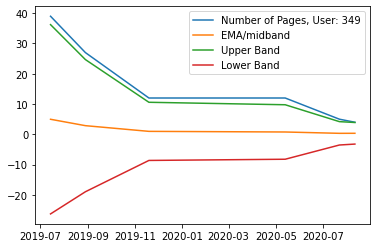

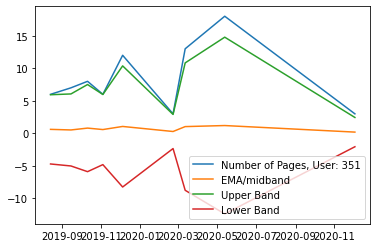

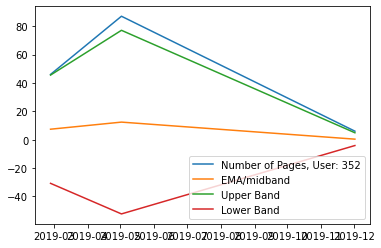

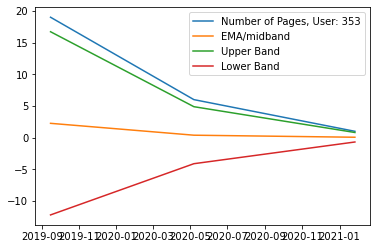

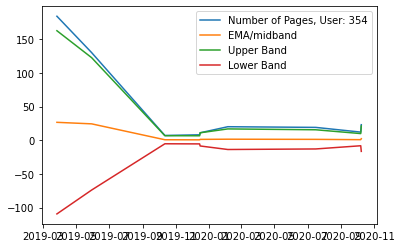

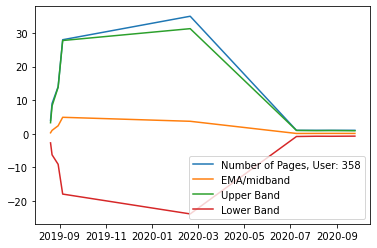

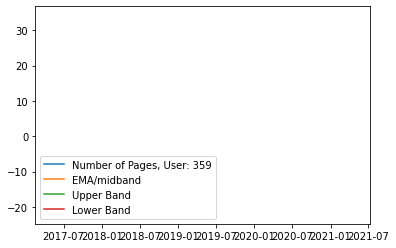

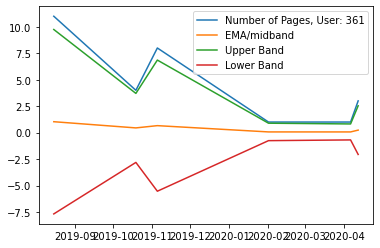

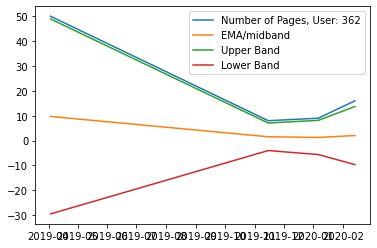

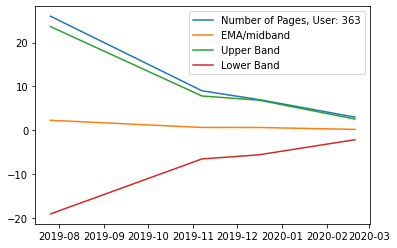

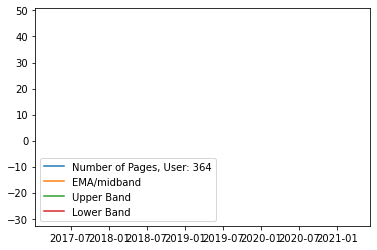

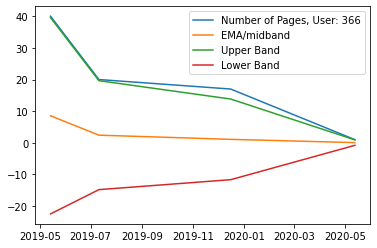

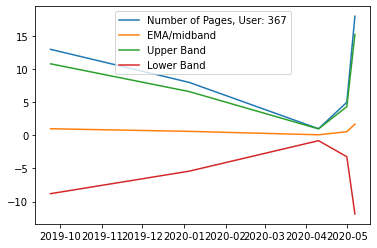

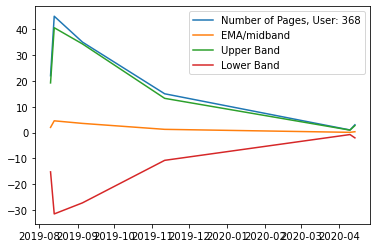

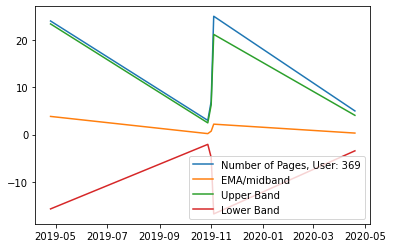

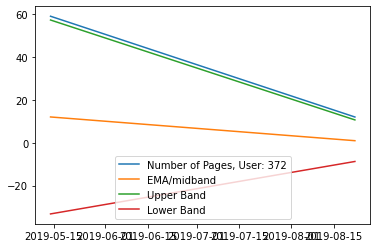

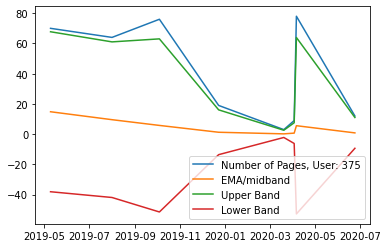

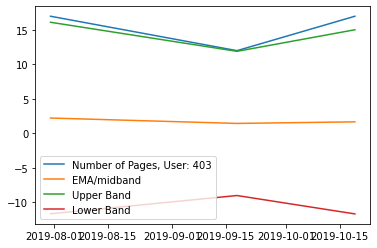

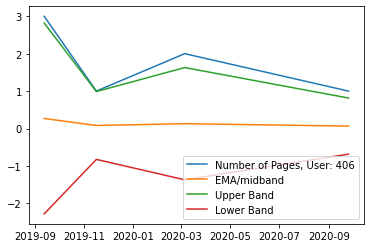

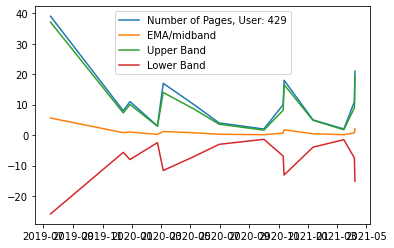

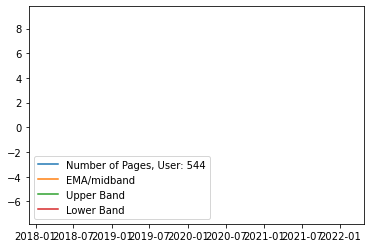

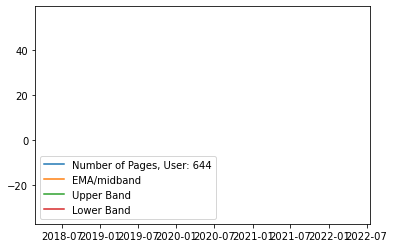

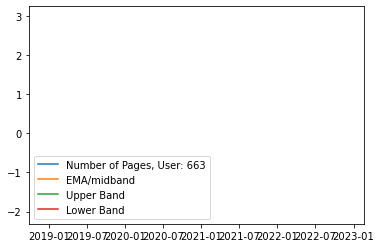

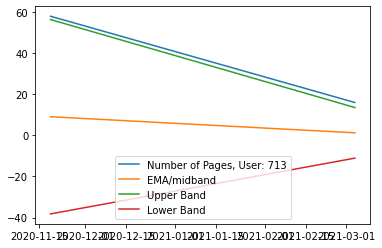

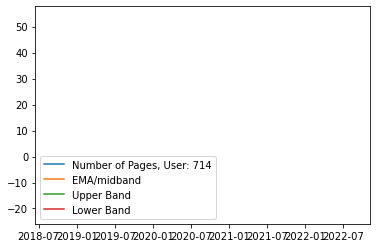

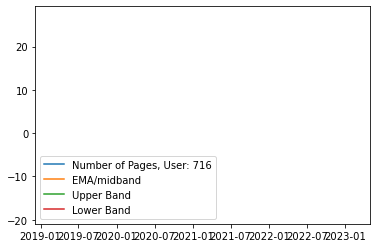

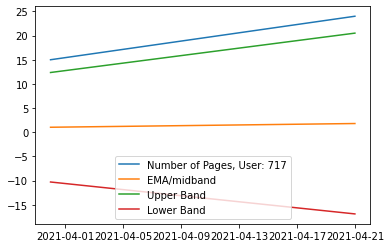

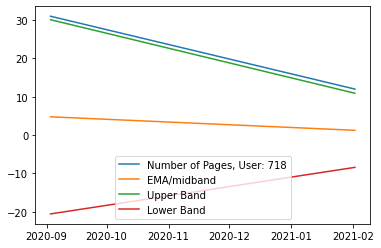

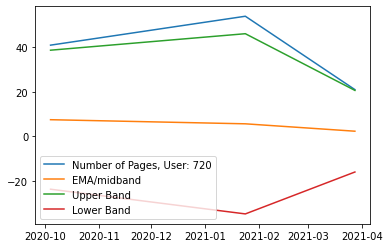

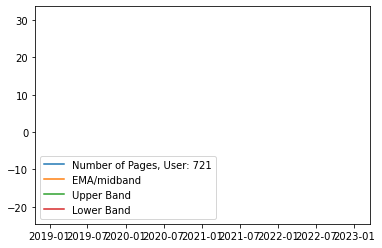

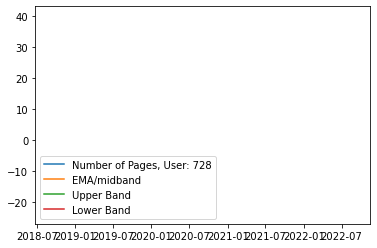

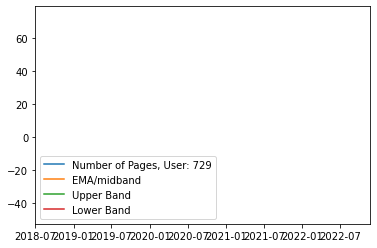

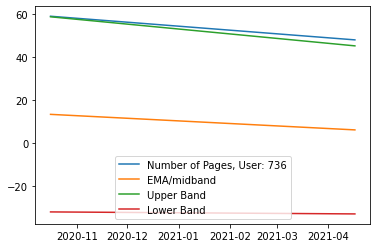

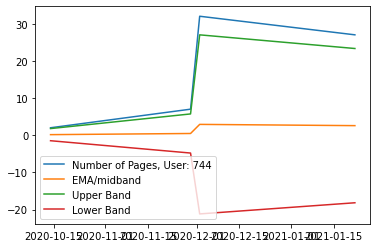

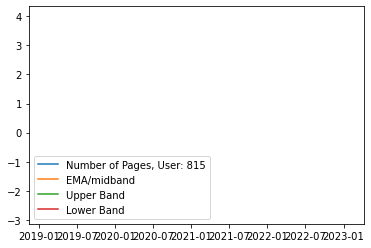

In [28]:
plot_bands_two(anomalies, list(sus))

# Same process for IP addresses

In [29]:
df.head()

,time,endpoint,user,source_ip,cohort_name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [30]:
def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    #filters data frame to only show one user at a time
    df = df[df.source_ip == user]
    #counts how many pulls per day for the single user mentioned above
    # note 'endpoint' has no meaning. just needed a column to resample and count by
    # the real meaning is pulls per day per user which is df.user==user and resample('d').count()
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [31]:
one_user_df_prep(df, '97.105.19.61')

date
2018-01-26    458
2018-01-27      0
2018-01-28      0
2018-01-29    652
2018-01-30    466
             ... 
2018-07-09    580
2018-07-10    452
2018-07-11    511
2018-07-12    513
2018-07-13    462
Freq: D, Name: endpoint, Length: 169, dtype: int64

In [32]:
l = one_user_df_prep(df, '97.105.19.61')

In [33]:
def compute_pct_b(pages_one_user, span, weight, user):
    ############# single user, ewm(span), weight = K, user #
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band-these are just standard equations
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe-combining data succinctly into a dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe - keep comibining
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    # eqn for %b
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    # add column to display user id
    my_df['source_ip'] = user
    return my_df

In [34]:
compute_pct_b(l, 30, 2, '97.105.19.61')

,pages_one_user,midband,ub,lb,pct_b,source_ip
date,,,,,,
2018-01-26,458,458.000000,NaN,NaN,NaN,97.105.19.61
2018-01-27,0,221.366667,869.076478,-426.343145,0.329116,97.105.19.61
2018-01-28,0,142.605702,662.473369,-377.261966,0.362844,97.105.19.61
2018-01-29,652,282.962394,954.428552,-388.503765,0.774800,97.105.19.61
2018-01-30,466,324.607881,921.385692,-272.169931,0.618463,97.105.19.61
...,...,...,...,...,...,...
2018-07-09,580,313.650145,951.729507,-324.429216,0.708712,97.105.19.61
2018-07-10,452,322.576081,943.589497,-298.437335,0.604204,97.105.19.61
2018-07-11,511,334.732640,942.715306,-273.250026,0.644961,97.105.19.61


In [35]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user-see earlier function
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return records that sit outside of bollinger band upper/lower limit
    #note: we don't expect any below the lower limit based on what we saw in the overall graph
    # the lower limit is 2(sigma) which happens to result in '-' values
    # but you can't have '-' of pulls
    return my_df[(my_df.pct_b>1) | (my_df.pct_b<0)]

In [36]:
find_anomalies(df, '97.105.19.61', 30, 3)

,pages_one_user,midband,ub,lb,pct_b,source_ip
date,,,,,,


In [37]:
df.source_ip.nunique()

5531

In [38]:
df.source_ip.unique()

array(['97.105.19.61', '71.137.146.71', '209.205.123.242', ...,
       '134.250.1.82', '174.197.2.198', '107.77.169.13'], dtype=object)

In [39]:
l = ['97.105.19.61', '71.137.146.71', '209.205.123.242']

In [40]:
l

['97.105.19.61', '71.137.146.71', '209.205.123.242']

In [41]:
span = 30
weight = 3

anomalies_ip = pd.DataFrame()
for u in l:
    user_df_ip = find_anomalies(df, u, span, weight)
    anomalies_ip = pd.concat([anomalies_ip, user_df_ip], axis=0)

In [42]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
...,...,...,...,...,...,...
2021-04-13,42,6.722117,39.398133,-25.953900,1.039813,884
2021-04-14,67,12.322021,63.449584,-38.805542,1.034721,888
2021-04-20,53,11.548548,50.739988,-27.642892,1.028833,919


In [43]:
list(df.source_ip.unique())

['97.105.19.61',
 '71.137.146.71',
 '209.205.123.242',
 '192.171.117.210',
 '12.189.101.90',
 '104.193.225.250',
 '12.247.3.42',
 '174.207.5.52',
 '172.3.220.202',
 '107.77.100.125',
 '96.8.150.23',
 '24.26.254.147',
 '72.191.50.176',
 '108.65.244.91',
 '76.185.247.126',
 '107.204.132.6',
 '173.174.155.172',
 '72.179.161.39',
 '72.177.226.58',
 '174.207.1.185',
 '70.123.231.211',
 '72.191.29.130',
 '65.36.105.55',
 '12.247.3.50',
 '173.173.127.101',
 '173.127.33.241',
 '162.232.155.19',
 '99.203.26.41',
 '96.8.179.59',
 '70.114.139.150',
 '72.181.117.226',
 '71.42.140.139',
 '45.22.97.134',
 '173.173.104.57',
 '104.53.201.99',
 '173.174.159.45',
 '67.10.161.55',
 '184.226.6.201',
 '76.211.179.43',
 '24.160.159.122',
 '66.69.62.219',
 '209.205.122.186',
 '24.153.137.59',
 '67.10.168.76',
 '70.123.209.40',
 '67.198.116.192',
 '98.6.204.195',
 '24.155.140.118',
 '162.205.226.57',
 '173.173.100.228',
 '65.36.111.91',
 '184.203.148.135',
 '72.181.97.136',
 '72.181.118.217',
 '67.11.104.47',

In [44]:
span = 30
weight = 3

anomalies_ip = pd.DataFrame()
for u in list(df.source_ip.unique()):
    user_df_ip = find_anomalies(df, u, span, weight)
    anomalies_ip = pd.concat([anomalies_ip, user_df_ip], axis=0)

In [45]:
anomalies_ip

,pages_one_user,midband,ub,lb,pct_b,source_ip
date,,,,,,
2018-03-14,9,0.627485,7.549265,-6.294295,1.104795,71.137.146.71
2018-05-06,10,0.727782,8.399771,-6.944207,1.104290,71.137.146.71
2018-05-14,72,9.145740,67.060810,-48.769330,1.042642,192.171.117.210
2018-06-30,56,8.695230,53.339983,-35.949523,1.029791,192.171.117.210
2018-07-30,604,51.705165,498.194976,-394.784646,1.118485,192.171.117.210
...,...,...,...,...,...,...
2021-04-19,27,3.769579,26.679626,-19.140468,1.006992,66.69.58.238
2021-04-20,53,11.548548,50.739988,-27.642892,1.028833,72.191.142.5
2021-04-15,42,8.313504,39.565607,-22.938598,1.038948,136.50.58.119


In [47]:
anomalies_ip.source_ip.nunique()

1371

In [ ]:
# Way too many to look at in our timeframe

In [48]:
anomalies_ip.pages_one_user.nunique()

132

In [ ]:
# I will once again, split data by those with a cohort name and those without

In [49]:
sus = np.intersect1d(coh_nam_na.user.unique(),anomalies.pages_one_user.unique())
sus

array([ 48,  54,  58,  59,  61,  62,  63,  64,  73,  74,  78,  79,  86,
        88,  89, 103])

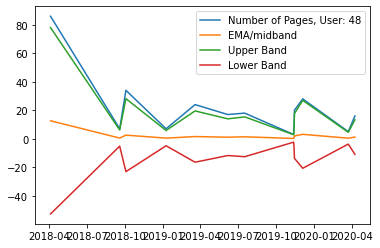

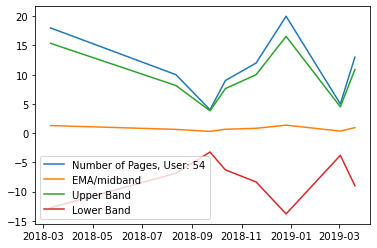

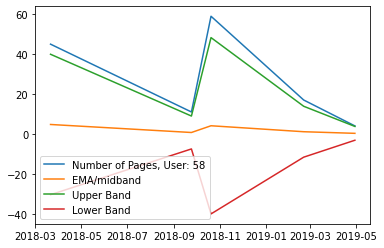

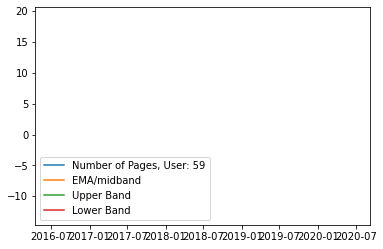

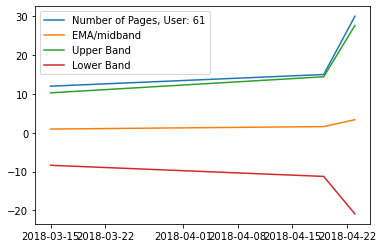

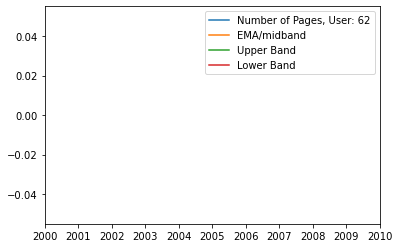

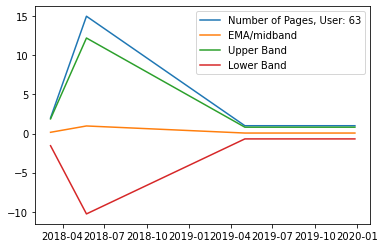

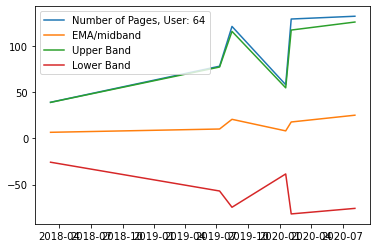

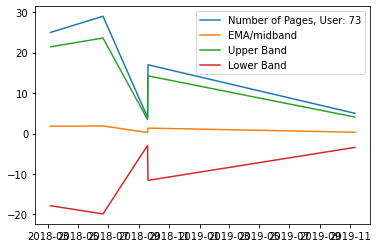

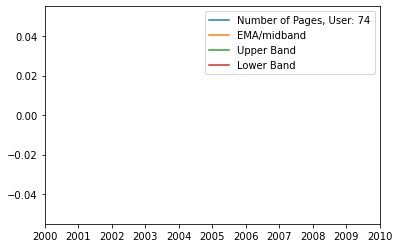

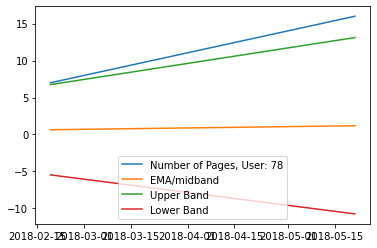

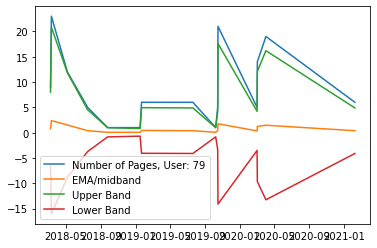

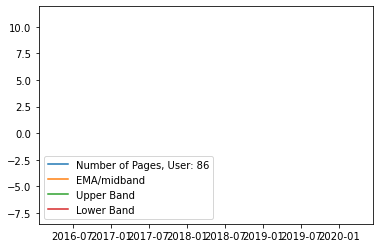

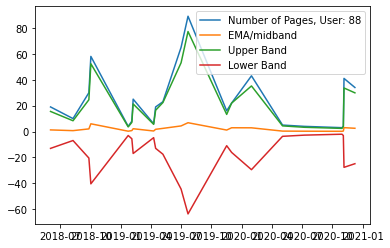

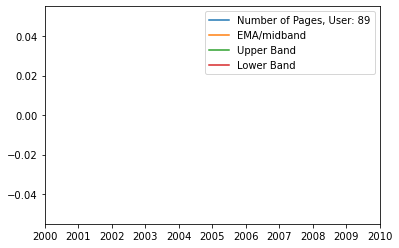

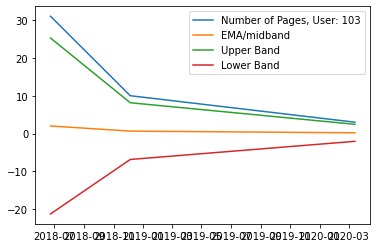

In [54]:
plot_bands_two(anomalies, list(sus))

In [ ]:
#Graphs backtrack on themselves because multiple useres can use the same source_ip in a day

In [ ]:
sus_user = [ 48,  54,  58,  59,  61,  63,  64,  73,  78,  79,  86,  88, 103,
       111, 166, 213, 346, 349, 351, 352, 353, 354, 358, 359, 361, 362,
       363, 364, 366, 367, 368, 369, 372, 375, 403, 406, 429, 544, 644,
       663, 713, 714, 716, 717, 718, 720, 721, 728, 729, 736, 744, 815]

In [ ]:
sus_ip = np.intersect1d(coh_nam_na.user.unique(),anomalies_ip.pages_one_user.unique())
sus

In [ ]:
sus = np.intersect1d(sus_user, sus_ip)
sus

# Final Answer
- No cohort name  AND
- Suspect Individual user data AND
- User when Suspect Source_IP activity was occuring

Users 48,  54,  58,  59,  61,  63,  64,  73,  78,  79,  86,  88, 103

In [ ]:
def plot_bands_two(my_df, users):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    for user in users:
        temp_df = my_df[my_df.user == user]
        plt.figure()
        plt.plot(temp_df.index, temp_df.pages_one_user, label='Number of Pages, User: '+str(user))
        plt.plot(temp_df.index, temp_df.midband, label = 'EMA/midband')
        plt.plot(temp_df.index, temp_df.ub, label = 'Upper Band')
        plt.plot(temp_df.index, temp_df.lb, label = 'Lower Band')
        plt.legend()
        plt.show()

In [ ]:
plot_bands_two(anomalies, list(sus))

In [ ]:
# Subject anomalies

In [ ]:
df_na[df_na.endpoint.str.contains('ds')].tail(100)

In [ ]:
#split the endpoint into 4 different sections using / as sepeartor and concatenate to the dataframe
df= pd.concat([df, df.endpoint.str.split(‘/’,3, expand = True)], axis=1)
df.head(1)